In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random as rn
import numpy as np
import json
import cv2
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pd.options.mode.chained_assignment = None

from IPython.core.interactiveshell import InteractiveShell   
InteractiveShell.ast_node_interactivity = "all"

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
os.listdir('/kaggle/input/cassava-leaf-disease-classification')


['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [5]:
with open('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    print(json.loads(f.read()))

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [6]:
img_lbl = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
img_lbl.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [8]:
img_lbl=img_lbl[~img_lbl['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]

In [9]:
img_lbl['label'].value_counts()

label
3    13158
4     2575
2     2386
1     2189
0     1086
Name: count, dtype: int64

In [10]:
X=[]   # variable to store leaf images
Z=[]   # variable to store leaf diseases

for img, dseas in tqdm(img_lbl.sample(9).values):
    image=cv2.imread('/kaggle/input/cassava-leaf-disease-classification/train_images/{}'.format(img),
                     cv2.IMREAD_COLOR)
    image=cv2.resize(image,(600,600))
    X.append(image)    # Appending the images into X
    Z.append(dseas)    # Appending the image labels into Z

100%|██████████| 9/9 [00:00<00:00, 38.49it/s]


Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 2')

Text(0.5, 1.0, 'Disease Class : 4')

Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 4')

Text(0.5, 1.0, 'Disease Class : 3')

Text(0.5, 1.0, 'Disease Class : 2')

Text(0.5, 1.0, 'Disease Class : 3')

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

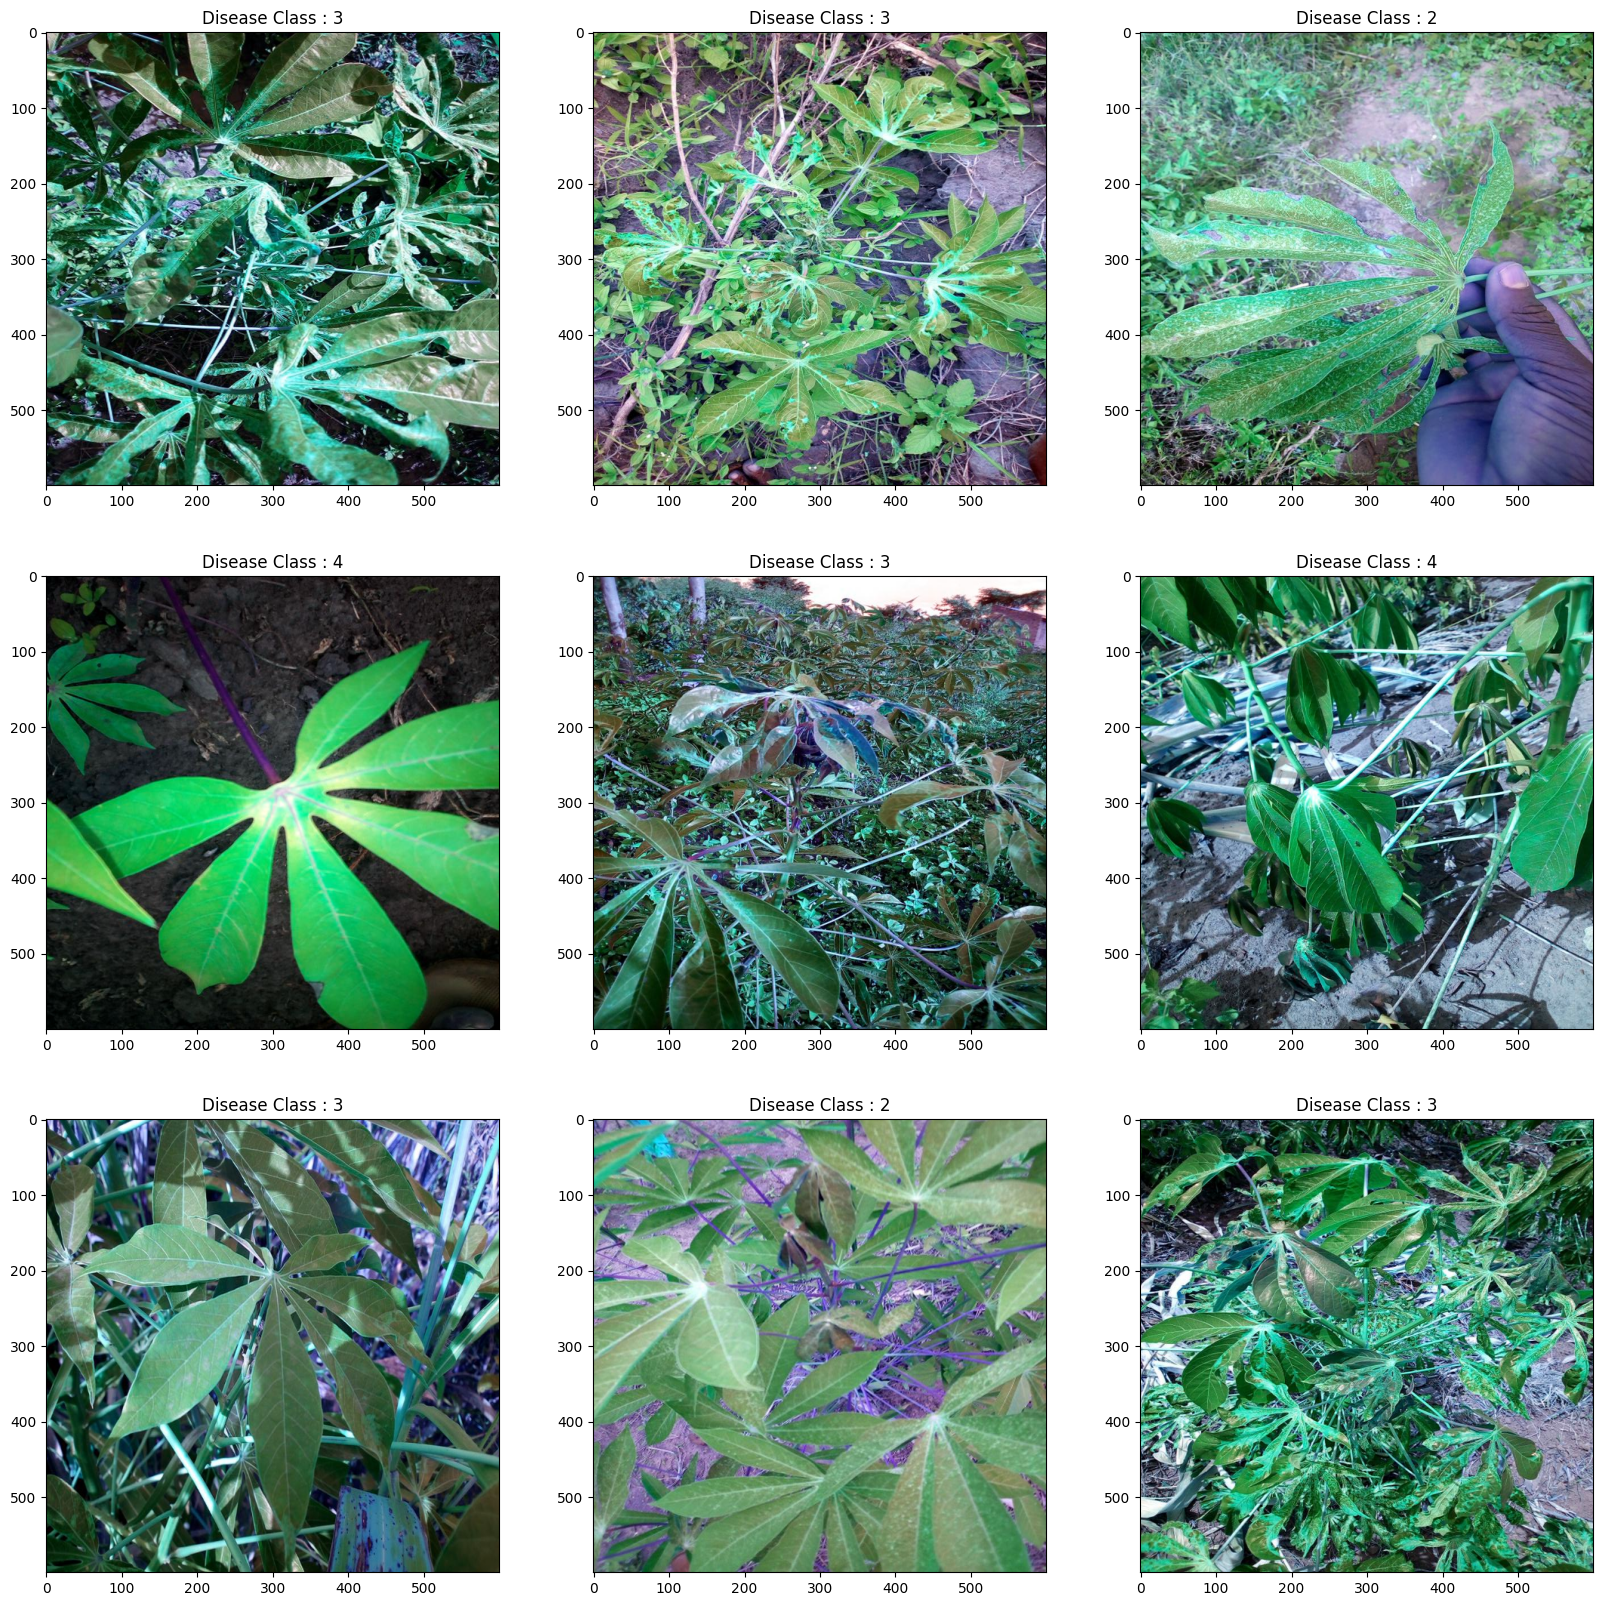

In [11]:
fig, ax=plt.subplots(3,3)
fig.set_size_inches(20,20)
l=0
for row in range(3):    
    for col in range(3):
        ax[row,col].imshow(X[l])
        ax[row,col].set_title('Disease Class : '+str(Z[l]))
        l=l+1

plt.tight_layout
sns.set(font_scale=1.5)

In [12]:
from sklearn.model_selection import train_test_split
train,validation = train_test_split(img_lbl,test_size=0.2,shuffle=True,stratify=img_lbl['label'])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Flatten,Dropout
from tensorflow.keras.applications import EfficientNetB3

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imagedatagenerator for training
datagen_trng = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                  rotation_range=30,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# label should be converted to string to be used
train['label']=train['label'].astype('str')                        

# Augmenting Images for training
train_datagen=datagen_trng.flow_from_dataframe(dataframe=train,
                                        directory='/kaggle/input/cassava-leaf-disease-classification/train_images',
                                        x_col="image_id",
                                        y_col="label",
                                        color_mode="rgb",
                                        target_size=(300,300),
                                        batch_size=4,
                                        seed=42,
                                        class_mode="categorical")

Found 17115 validated image filenames belonging to 5 classes.


In [16]:
# Imagedatagenerator for validation
datagen_valid = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# label should be converted to string to be used
validation['label']=validation['label'].astype('str')

# Augmenting Images for validating
valid_datagen=datagen_valid.flow_from_dataframe(dataframe=validation,
                                        directory='/kaggle/input/cassava-leaf-disease-classification/train_images',
                                        x_col='image_id',
                                        y_col="label",
                                        color_mode="rgb",
                                        target_size=(300,300),
                                        batch_size=4,
                                        seed=42,
                                        class_mode="categorical")

Found 4279 validated image filenames belonging to 5 classes.


In [17]:
# Defining model

model=Sequential()
model.add(EfficientNetB3(include_top=False,weights='imagenet',input_shape=(300,300,3)))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

43941136/43941136 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33

In [18]:
# Defining callbacks

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='val_categorical_accuracy',
                         min_delta=0.002,
                         patience=3,
                         mode='max',
                         verbose=1,
                         restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_categorical_accuracy',
                            patience=2,
                            factor=0.1,
                            mode='max',
                            min_lr=1e-6,
                            verbose=1)

In [19]:
history= model.fit(train_datagen,
                   batch_size=train_datagen.n//train_datagen.batch_size,
                   epochs=25,verbose=1,shuffle=True,
                   validation_data=valid_datagen,
                   callbacks=[early_stop,reduce_lr])

Epoch 1/25


2023-10-06 16:12:50.158680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4279/4279 [==============================] - 797s 169ms/step - loss: 1.0563 - categorical_accuracy: 0.6252 - val_loss: 1.3076 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 2/25
4279/4279 [==============================] - 662s 155ms/step - loss: 0.9190 - categorical_accuracy: 0.6628 - val_loss: 0.8347 - val_categorical_accuracy: 0.6913 - lr: 0.0010
Epoch 3/25
4279/4279 [==============================] - 655s 153ms/step - loss: 0.8414 - categorical_accuracy: 0.6857 - val_loss: 0.7406 - val_categorical_accuracy: 0.7109 - lr: 0.0010
Epoch 4/25
4279/4279 [==============================] - 660s 154ms/step - loss: 0.7895 - categorical_accuracy: 0.7098 - val_loss: 0.6720 - val_categorical_accuracy: 0.7761 - lr: 0.0010
Epoch 5/25
4279/4279 [==============================] - 649s 152ms/step - loss: 0.7389 - categorical_accuracy: 0.7334 - val_loss: 0.6518 - val_categorical_accuracy: 0.7836 - lr: 0.0010
Epoch 6/25
4279/4279 [==============================] - 657s 154ms/step - loss: 0.7092

In [20]:
model_eval=model.evaluate(valid_datagen,verbose=1)
print('Validation loss: ',model_eval[0])
print('Validation accuracy: ',model_eval[1])

1070/1070 [==============================] - 30s 28ms/step - loss: 0.4803 - categorical_accuracy: 0.8518
Validation loss:  0.48032525181770325
Validation accuracy:  0.8518345355987549


[None, None, None]

[None, None, None]

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

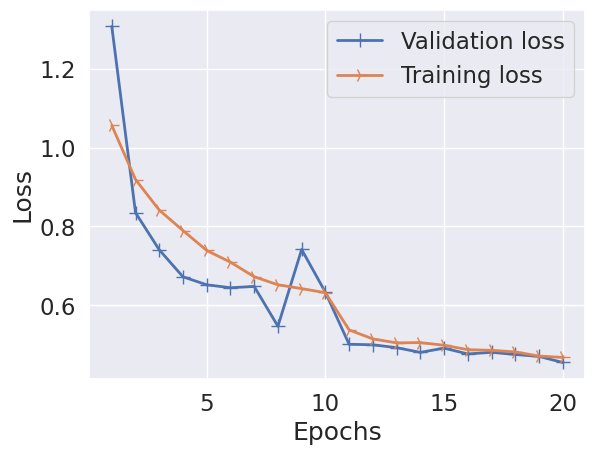

In [21]:
history_dict=history.history

loss_value=history_dict['loss']
val_loss_value=history_dict['val_loss']
epoch=range(1,len(loss_value)+1)

lin1=plt.plot(epoch,val_loss_value,label='Validation loss')
lin2=plt.plot(epoch,loss_value,label='Training loss')
plt.setp(lin1,linewidth=2.0,marker='+',markersize=10.0)
plt.setp(lin2,linewidth=2.0,marker='4',markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

[None, None, None]

[None, None, None]

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Categorical Accuracy')

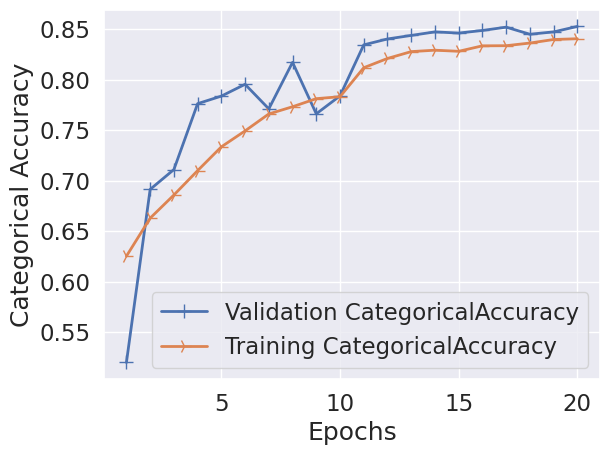

In [22]:
acc_value=history_dict['categorical_accuracy']
val_acc_value=history_dict['val_categorical_accuracy']
epoch=range(1,len(loss_value)+1)

lin1=plt.plot(epoch,val_acc_value,label='Validation CategoricalAccuracy')
lin2=plt.plot(epoch,acc_value,label='Training CategoricalAccuracy')
plt.setp(lin1,linewidth=2.0,marker='+',markersize=10.0)
plt.setp(lin2,linewidth=2.0,marker='4',markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.grid(True)
plt.legend()

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming 'model' is your trained Keras model

# Generate predictions for the validation dataset
valid_predictions = model.predict(valid_datagen, verbose=1)
# Convert predicted probabilities to class labels
valid_predicted_labels = np.argmax(valid_predictions, axis=1)

# Get the true labels from the validation data generator
valid_true_labels = valid_datagen.classes

# Compute the classification report
class_names = list(valid_datagen.class_indices.keys())  # Replace with your class labels
report = classification_report(valid_true_labels, valid_predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

# Compute the confusion matrix
confusion = confusion_matrix(valid_true_labels, valid_predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion)

1070/1070 [==============================] - 29s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.05      0.05      0.05       217
           1       0.12      0.11      0.11       438
           2       0.10      0.09      0.09       477
           3       0.61      0.62      0.61      2632
           4       0.13      0.15      0.14       515

    accuracy                           0.42      4279
   macro avg       0.20      0.20      0.20      4279
weighted avg       0.42      0.42      0.42      4279

Confusion Matrix:
[[  11   22   23  138   23]
 [  30   49   31  267   61]
 [  12   54   42  306   63]
 [ 161  239  275 1620  337]
 [  23   55   50  312   75]]


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision.transforms as transforms

In [31]:
torch.save(model, '/kaggle/working/my_model.h5')